# **CS 418 Final Project: Data-Driven Course Insights: Predicting Grade Trends 💯**<br>
**Github Repository Link:**<br>

This project is to predict course grade distributions and popularity rankings for upcoming semesters, enabling students to make informed decisions about their class selections. By shifting the focus from individual grade predictions to overall course outcomes, the project provides insights into course grading trends and demand. It uses clustering to rank courses based on student performance and popularity, and topic-based grouping to help students discover courses aligned with their interests, factoring in professor expertise and class attributes. This data-driven tool uncovers hidden patterns, aiding both students and academic planning. <br>

**Authors:**
| **Name**  | **Email** | **Github Handle** | **Contributions** |
|---|---|---|---|
| Arlette Diaz | adiaz218@uic.edu | adiaz218 |[INSERT TEXT HERE..]|
| Marianne Hernandez | mhern85@uic.edu | marhern19 |[INSERT TEXT HERE..]|
| Nandini Jirobe | njiro2@uic.edu | nandinijirobe |Collected RMP ratings and Google Scholar research interests for ME, IE, and CS professors (2014-2024). Gathered UIC course descriptions for CS classes. Created Data Visualization #1.|
| Sharadruthi Muppidi | smuppi2@uic.edu | sharadruthi-uic |[INSERT TEXT HERE..]|
| Sonina Mut | smut3@uic.edu | snina22 |[INSERT TEXT HERE..]|
| Yuting Lu | lyuti@uic.edu | yutinglu103 |[INSERT TEXT HERE..]|

### **Part 1: Install & Import Libraries 📦**

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings

warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import make_interp_spline

### **Part 2: Load Datasets 🔄**

In [22]:
cs_grades = pd.read_csv('uic_GD_CS_14_24.csv') # CS courses Grade distribution data
meie_grades = pd.read_csv('uic_GD_MEIE_14_24.csv') # ME/IE courses Grade distribution data
cs_rmp = pd.read_csv('uic_RMP_CS_14_24.csv') # CS Rate My Professor Data
meie_rmp = pd.read_csv('CS418_Team5_DataSet - RMP_MEIE_14_24.csv') # ME/IE Rate My Professor Data
cs_gs = pd.read_csv('CS418_Team5_DataSet - GS_CS_14_24.csv') # CS Professor Google Scholar Data
meie_gs = pd.read_csv('CS418_Team5_DataSet - GS_MEIE_14_24.csv') # ME/IE Professor Google Scholar Data
cs_lectures = pd.read_csv('uic_CS_lectures_all_semesters.csv') # CS Lecture Data
me_lectures = pd.read_csv('uic_ME_lectures_all_semesters.csv') # ME Lecture Data
ie_lectures = pd.read_csv('uic_IE_lectures_all_semesters.csv') # IE Lecture Data
cs_descrip = pd.read_csv('CS418_Team5_DataSet - CS_Descrip.csv') # Course Description Data

### **Part 3: Data Cleaning 🧹**

In [23]:
# ============== Dataset 1: Grade Distribution ============== #
grade_dist = pd.concat([cs_grades, meie_grades], ignore_index=True) # Append both CS and ME/IE dataframes
grade_dist = grade_dist.loc[:, (grade_dist != 0).any(axis=0)] # Drop columns where all values are zero
grade_dist = grade_dist[~grade_dist['CRS TITLE'].str.contains("research|seminar", case=False, na=False)] # Drop rows where CRS TITLE (course title) contains "research" or "seminar" (case-insensitive)
grade_dist.rename(columns={'Primary Instructor': 'Instructor'}, inplace=True) # Rename column
grade_dist.rename(columns={'CRS NBR': 'CRS NUM'}, inplace=True) # Rename column
grade_dist = grade_dist[grade_dist['CRS NUM'].between(100, 599)] # Filter for courses
grade_dist["CRS LVL"] = (grade_dist["CRS NUM"]//100)*100
grade_dist.drop(["DFR", "I", "NR", "S", "U", "DEPT CD"], axis=1, inplace=True) # drop unecessary columns

# Convert all numeric columns to integers or floats
for col in grade_dist.columns:
    grade_dist[col] = pd.to_numeric(grade_dist[col], errors='ignore')

grade_dist.head(5)

,YEAR,SEMESTER,CRS SUBJ CD,CRS NUM,CRS TITLE,DEPT NAME,A,B,C,D,F,W,Instructor,Grade Regs,CRS LVL
0,2014,Spring,CS,100,Discovering Computer Science,Computer Science,21,12,9,0,2,2,"Reed, Dale F",46,100
1,2014,Spring,CS,107,Intro Comp & Programming,Computer Science,15,24,19,12,8,11,"Theys, Mitchell D",89,100
2,2014,Spring,CS,109,Prog for Engineers w/MatLab,Computer Science,59,44,38,1,10,16,"Hummel, Joseph E",168,100
3,2014,Spring,CS,111,Program Design I,Computer Science,38,30,13,3,7,6,"Troy, Patrick A",97,100
4,2014,Spring,CS,141,Program Design II,Computer Science,33,33,33,12,15,3,"Reed, Dale F",129,100


In [24]:
# ============== Dataset 2: Rate My Professor ============== #
rate_my_prof = pd.concat([cs_rmp, meie_rmp], ignore_index=True) # Append both CS and ME/IE rmp dataframes

# Convert all numeric columns rate_my_prof to integers or floats
rate_my_prof["Rating"] = pd.to_numeric(rate_my_prof["Rating"], errors='coerce')
rate_my_prof["Num Reviews"] = pd.to_numeric(rate_my_prof["Num Reviews"], errors='coerce')

# Fill missing values with average values of that column
rate_my_prof['Rating'] = rate_my_prof['Rating'].fillna(rate_my_prof["Rating"].mean())
rate_my_prof['Num Reviews'] = rate_my_prof['Num Reviews'].fillna(rate_my_prof["Num Reviews"].mean())

# Merge the grade distribution and RMP datasets
grade_dist_rmp = pd.merge(grade_dist, rate_my_prof, on='Instructor', how='left')

grade_dist_rmp.head(5)

,YEAR,SEMESTER,CRS SUBJ CD,CRS NUM,CRS TITLE,DEPT NAME,A,B,C,D,F,W,Instructor,Grade Regs,CRS LVL,Rating,Num Reviews
0,2014,Spring,CS,100,Discovering Computer Science,Computer Science,21,12,9,0,2,2,"Reed, Dale F",46,100,3.5,128.0
1,2014,Spring,CS,107,Intro Comp & Programming,Computer Science,15,24,19,12,8,11,"Theys, Mitchell D",89,100,3.5,106.0
2,2014,Spring,CS,109,Prog for Engineers w/MatLab,Computer Science,59,44,38,1,10,16,"Hummel, Joseph E",168,100,3.8,82.0
3,2014,Spring,CS,111,Program Design I,Computer Science,38,30,13,3,7,6,"Troy, Patrick A",97,100,4.3,74.0
4,2014,Spring,CS,141,Program Design II,Computer Science,33,33,33,12,15,3,"Reed, Dale F",129,100,3.5,128.0


In [25]:
# ============== Dataset 3: CLASS SCHEDULER DATA ============== #

# ============== Dataset 3: Helper Functions ============== #
def update_method_type(method_type: str) -> str:
    """
    Standardize method type names across different years
    """
    method_mapping = {
        'Online Synchronous': ['Meet online at set times'],
        'Online Asynchronous': ['Online with deadlines'],
        'On Campus': ['Meet on campus'],
        'Hybrid': ['On campus and online', 'Mixed in-person & online instr']
    }

    for standard_name, variants in method_mapping.items():
        if method_type == standard_name or method_type in variants:
            return standard_name

    return method_type

def process_lecture_data(cs_lectures: pd.DataFrame, me_lectures: pd.DataFrame, ie_lectures: pd.DataFrame) -> pd.DataFrame:
    """
    Process and combine lecture data from different departments
    """
    # Combine all dataframes
    all_lecture_data = pd.concat([cs_lectures, me_lectures, ie_lectures], ignore_index=True)

    # Convert year to numeric
    all_lecture_data["Year"] = pd.to_numeric(all_lecture_data["Year"], errors='coerce')

    # Split course code into subject and number
    all_lecture_data[['CRS SUBJ CD', 'CRS NUM']] = all_lecture_data['Course Code'].str.split(' ', expand=True)

    # Standardize method types
    all_lecture_data['Method'] = all_lecture_data['Method'].apply(update_method_type)

    final_columns = [
        'CRS SUBJ CD',
        'CRS NUM',
        'Days per Week',  # Changed from 'Days' to match actual column name
        'Instructor',
        'Method',
        'Semester',
        'Year',
        'Time of Day',
        'Duration of Class (minutes)'
    ]

    # Select only needed columns in specified order
    result = all_lecture_data[final_columns]
    result = result.rename(columns={'Days per Week': 'Days'}) # Rename the 'Days per Week' column to 'Days'
    return result

# ============== Dataset 3: Lecture Data Cleaning ============== #
processed_data = process_lecture_data(cs_lectures, me_lectures, ie_lectures)
processed_data.head(5)

,CRS SUBJ CD,CRS NUM,Days,Instructor,Method,Semester,Year,Time of Day,Duration of Class (minutes)
0,CS,100,3,"Reed, D",On Campus,Spring,2014,Afternoon,50
1,CS,107,2,"Theys, M",On Campus,Spring,2014,Afternoon,75
2,CS,109,2,"Hummel, J",On Campus,Spring,2014,Afternoon,50
3,CS,111,2,"Troy, P",On Campus,Spring,2014,Afternoon,75
4,CS,141,3,"Reed, D",On Campus,Spring,2014,Afternoon,50


### **Part 4: Data Visualizations 📊**<br>
#### **Data Visualization #1: Average Grade of Course Level in Computer Science** <br>
**Hypothesis:** [TODO: ill do this later --nandini] <br>
**Conclusion:** [TODO: ill do this later --nandini]

Text(0.5, 1.0, 'Avg Grade of Each Course Level in Computer Science')

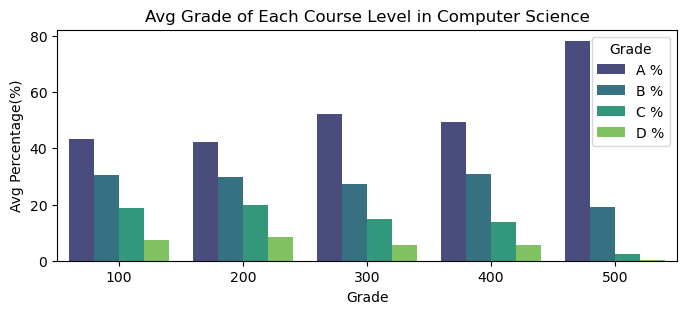

In [26]:
# save a copy of just the cs clases into gd_copy
gd_copy = grade_dist[grade_dist["CRS SUBJ CD"] == "CS"]

# Calculate the grade distribution as a percentage of the total registered students
for grade in ['A', 'B', 'C', 'D', 'F']:
    gd_copy[f'{grade} %'] = (gd_copy[grade] / gd_copy['Grade Regs']) * 100

# calculate percentages of A, B, C, D grades in each course level
gd_copy = gd_copy.groupby("CRS LVL")[["A %", "B %", "C %", "D %"]].mean().reset_index()
gd_copy["sum"] = gd_copy['A %'] + gd_copy['B %'] + gd_copy['C %'] + gd_copy['D %']
gd_copy["A %"] = (gd_copy["A %"]/gd_copy["sum"])*100
gd_copy["B %"] = (gd_copy["B %"]/gd_copy["sum"])*100
gd_copy["C %"] = (gd_copy["C %"]/gd_copy["sum"])*100
gd_copy["D %"] = (gd_copy["D %"]/gd_copy["sum"])*100

# this rotates the dataframe so it is into long format instead of wide format
gd_copy= gd_copy.melt(id_vars=["CRS LVL"], value_vars=["A %", "B %", "C %", "D %"], var_name="Grade", value_name="Avg percent")

# Use seaborn barplot to plot the figure above. Customize with color palette='viridis'
plt.figure(figsize=(8,3))
avgCSgrades_bar_chart = sns.barplot(data=gd_copy, x = 'CRS LVL', y = 'Avg percent', hue='Grade', palette='viridis')
avgCSgrades_bar_chart.set_xlabel("Grade")
avgCSgrades_bar_chart.set_ylabel("Avg Percentage(%)")
avgCSgrades_bar_chart.set_title("Avg Grade of Each Course Level in Computer Science")

**Conclusion:**

Higher level computer science courses, particularly courses at the 500 level, have a higher percentage of students receiving "A" grade indicates than lower level courses, according to the visualization. This implies that advanced courses are typically taken by students who are more motivated or prepared, such as graduate students, or that advanced course grading specifications are flexible. However, the comparatively greater rates of C's and D's in 100 and 200 level courses might be an indication of the difficulties beginning students have adjusting to college level coursework. Administrators and instructors can use these data to determine places where lower level courses might benefit from extra assistance to enhance student performance.

#### **Data Visualization #2: Online Course Percentage by Year for Different Departments**

**Hypothesis:** After the pandemic, computer science courses are still able to be offered online compared to more hands-on majors such as Industrial or Mechanical Engineering.

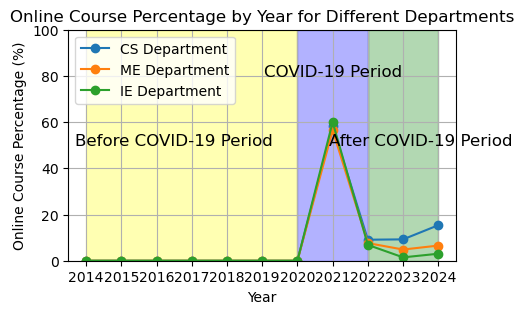

In [27]:
cs_data = cs_lectures # get data in CS department
cs_data['Is_Online'] = cs_data['Method'].str.contains('Online', case=False, na=False) # mark online course
cs_online_ratio_by_year = cs_data.groupby('Year')['Is_Online'].mean() * 100 # calculate the ratio of online course for each year
cs_online_ratio_df = cs_online_ratio_by_year.reset_index() # Create new table
cs_online_ratio_df.columns = ['Year', 'Online_Course_Percentage']

ie_data = ie_lectures # get data in IE department
ie_data['Is_Online'] = ie_data['Method'].str.contains('Online', case=False, na=False) # mark online course
ie_online_ratio_by_year = ie_data.groupby('Year')['Is_Online'].mean() * 100 # calculate the ratio of online course for each year
ie_online_ratio_df = ie_online_ratio_by_year.reset_index() # Create new table
ie_online_ratio_df.columns = ['Year', 'Online_Course_Percentage']

me_data = me_lectures # get data in ME department
me_data['Is_Online'] = me_data['Method'].str.contains('Online', case=False, na=False) # mark online course
me_online_ratio_by_year = me_data.groupby('Year')['Is_Online'].mean() * 100 # calculate the ratio of online course for each year
me_online_ratio_df = me_online_ratio_by_year.reset_index() # Create new table
me_online_ratio_df.columns = ['Year', 'Online_Course_Percentage']

plt.figure(figsize=(5, 3))
plt.plot(cs_online_ratio_df['Year'], cs_online_ratio_df['Online_Course_Percentage'], marker='o', linestyle='-', label='CS Department')
plt.plot(me_online_ratio_df['Year'], me_online_ratio_df['Online_Course_Percentage'], marker='o', linestyle='-', label='ME Department')
plt.plot(ie_online_ratio_df['Year'], ie_online_ratio_df['Online_Course_Percentage'], marker='o', linestyle='-', label='IE Department')

# add background
plt.axvspan(2014, 2020, color='yellow', alpha=0.3)
plt.text(2016.5, 50, 'Before COVID-19 Period', color='black', fontsize=12, ha='center')
plt.axvspan(2020, 2022, color='blue', alpha=0.3)
plt.text(2021, 80, 'COVID-19 Period', color='black', fontsize=12, ha='center')
plt.axvspan(2022, 2024, color='green', alpha=0.3)
plt.text(2023.5, 50, 'After COVID-19 Period', color='black', fontsize=12, ha='center')

plt.title('Online Course Percentage by Year for Different Departments')
plt.xlabel('Year')
plt.ylabel('Online Course Percentage (%)')
plt.xticks(range(2014, 2025))
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

**Conclusion:**
Changes in Online Course Proportion: 1. During COVID-19 Period, the proportion of online courses in all departments suddenly increased sharply, reaching nearly 100%. After COVID-19 Period, the proportion of online courses dropped significantly and stabilized. This indicates that after the pandemic, some courses returned to in-person instruction, although some habits of online teaching might have remained, especially in the CS department, which still had a relatively high proportion of online courses in 2023-2024 and most of the online courses are concentrated in the summer semester after COVID-19 for every department. 2.Differences Among Departments:After the the COVID-19 period, we can see that the CS department (blue line) retained more online courses, while the ME and IE departments largely returned to nearly 0% online courses.

#### **Data Visualization #3: Rate My Professor and Student Retention**<br>
**Hypothesis:** Student registrations increase with higher instructor ratings, while withdrawal rates decrease as ratings improve. <br>


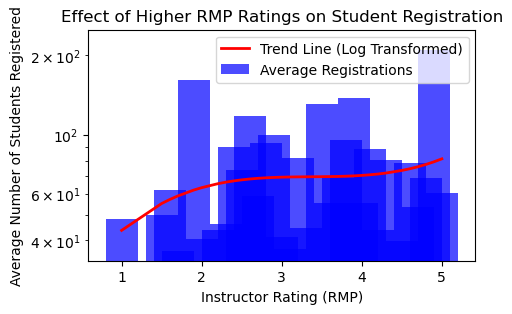

In [28]:
cs_grades['Primary Instructor'] = cs_grades['Primary Instructor'].str.strip()
cs_rmp['Instructor'] = cs_rmp['Instructor'].str.strip()
merged_data = pd.merge(cs_grades, cs_rmp, left_on='Primary Instructor', right_on='Instructor', how='inner')

grouped_courses = merged_data.groupby([ 'YEAR','SEMESTER', 'CRS NBR','CRS TITLE'])
multiple_instructors = grouped_courses.filter(lambda x: len(x['Primary Instructor'].unique()) > 2)
grouped_registrations = merged_data.groupby('Rating')['Grade Regs'].mean().reset_index()
x = grouped_registrations['Rating']
y = grouped_registrations['Grade Regs']
y_log = np.log(y)
coefficients = np.polyfit(x, y_log, deg=3)
trend_line_log = np.polyval(coefficients, x)

trend_line = np.exp(trend_line_log)
plt.figure(figsize=(5, 3))
plt.bar(x, y, width=0.4, color='blue', alpha=0.7, label='Average Registrations')
plt.yscale('log')
plt.plot(x, trend_line, color='red', linestyle='-', linewidth=2, label='Trend Line (Log Transformed)')
plt.xlabel('Instructor Rating (RMP)')
plt.ylabel('Average Number of Students Registered')
plt.title('Effect of Higher RMP Ratings on Student Registration')
plt.ylim(0, 250)
plt.legend()
plt.show()

**Conclusion: Effect of Higher RMP Ratings on Student Registration:**
The visualization examines the relationship between instructors' ratings on Rate My Professors (RMP) and the average number of students registering for their courses. The blue bars represent the average number of students registered at each instructor rating level, while the red curve serves as a logarithmic trend line, highlighting the overall trend in the data. Student registration and instructor ratings are positively correlated, according to the figure. More students are typically drawn to teachers with higher RMP ratings. There are far fewer students registered at low ratings (about 1-2) than at ratings in the 4-5 range. As ratings rise, the trend line shows that the number of registrants increases exponentially, leveling off at higher rating levels. This indicates that students are more tempted to sign up for classes offered by instructors who are more well-known or who are thought to be more effective teachers, as indicated by their RMP scores.

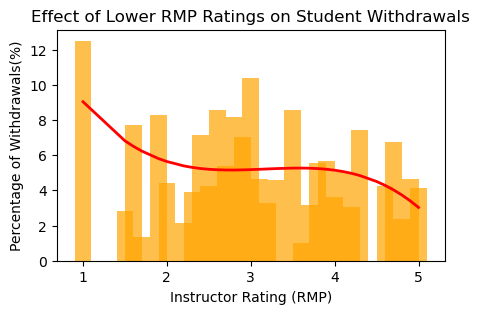

In [29]:
grouped_data = merged_data.groupby('Rating').agg({'W': 'sum', 'Grade Regs': 'sum'}).reset_index()
grouped_data['Withdraw_Rate'] = (grouped_data['W'] / grouped_data['Grade Regs'])*100
x = grouped_data['Rating']
y = grouped_data['Withdraw_Rate']
coefficients = np.polyfit(x, y, deg=3)
trend_line = np.polyval(coefficients, x)

plt.figure(figsize=(5, 3))
plt.bar(grouped_data['Rating'], grouped_data['Withdraw_Rate'], width=0.2, color='orange', alpha=0.7, label='Withdrawal Rate')
plt.plot(x, trend_line, color='red', linestyle='-', linewidth=2, label='Trend Line')
plt.xlabel('Instructor Rating (RMP)')
plt.ylabel('Percentage of Withdrawals(%)')
plt.title('Effect of Lower RMP Ratings on Student Withdrawals')
plt.show()

**Conclusion and Insights**

These visualizations demonstrate how instructor ratings have a big influence on student enrollment and retention. Higher RMP instructors successfully maintain their students in addition to drawing in new ones. On the other hand, lower rated instructors have trouble drawing in and keeping students, as seen by lower registrations and greater withdrawal rates.  These outcomes highlight the need of encouraging excellent teaching methods for educational institutions in order to raise student engagement and satisfaction. Enhancing teacher support through professional development programs can raise ratings, lower withdrawal rates, and ultimately improve the learning environment. It can also assist teachers in identifying and addressing areas for improvement by encouraging students to offer constructive criticism on their educational experiences. The importance of excellent instruction in fostering student achievement and engagement is shown by these outcomes.

### **Part 4: Machine Learning Analysis 🧠**

#### **Machine Learning #1: Grade Distribution Analysis Based on Class and RMP Data**

For our first prediction task, we chose the following machine learning models to predict the distribution of grades (A, B, C, D, F) based on features such as **Rating**, **Num Reviews**, **Class Size**, and **Semester Encoded**. To handle the multi-output nature of the problem (predicting multiple grade categories), a **MultiOutputRegressor** wrapper was used, enabling simultaneous predictions for all grade categories.

#### *Overview of Models:*
- **Gradient Boosting Regressor (GBR):**
  A **Gradient Boosting Regressor** was trained to predict the grade distribution (A, B, C, D, F) using the features **Rating**, **Num Reviews**, **Class Size**, and **Semester Encoded**. The **MultiOutputRegressor** wrapper was applied to handle the multi-output nature of predicting grade categories simultaneously.

- **Random Forest Regressor (RFR):**
  A **Random Forest Regressor** was also employed for the same task, wrapped with a **MultiOutputRegressor** for direct comparison. Both models used identical input features to ensure a fair comparison of their performance.

#### *Performance Highlights:*
##### Random Forest Regressor (RFR):
- Performed particularly well in predicting lower grades like **D** (MSE: 12.12) and **F** (MSE: 14.76).
- Struggled more with higher grades like **A** (MSE: 132.11), likely due to fewer observations in these categories.

#### Gradient Boosting Regressor (GBR):
- Outperformed RFR in most grade categories, particularly **A** (MSE: 131.83) and **B** (MSE: 56.54).
- Similar performance to RFR for **C** and **D**, but showed a slight advantage in predicting **F** (MSE: 15.50).

#### *Baseline Comparison:*
For both models, we compared performance against a baseline, which predicts the mean grade distribution for each category. This baseline provides a reference to evaluate the models' abilities to capture patterns in the data.

- **Baseline MSE**:
  The baseline MSE represents the variance in the grade distribution if the mean values were always predicted.
   - The **Mean Squared Error (MSE)** for the baseline model is calculated by predicting the mean for each grade category and measuring the variance from actual values.

#### *Performance Metrics (MSE for Each Grade Category):*
| **Grade Category** | **Gradient Boosting Regressor (GBR)** | **Random Forest Regressor (RFR)** |
|---------------------|---------------------------------------|-----------------------------------|
| **A**               | 131.83                                | 132.11                            |
| **B**               | 56.54                                 | 58.68                             |
| **C**               | 36.06                                 | 35.49                             |
| **D**               | 11.81                                 | 12.12                             |
| **F**               | 15.50                                 | 14.76                             |

#### *Insights from MSE Comparison:*
- The **Gradient Boosting Regressor** outperforms the **Random Forest Regressor** in most grade categories, with **lower MSE values** for Grades A, B, and D.
- For **Grade F**, the Random Forest model achieved a slightly lower MSE, suggesting a better performance in predicting failing grades.
- Both models performed well in predicting **Grade D**, with relatively low MSE values across models.

#### *Feature Importance Analysis:*
| **Feature**         | **GBR Importance** | **RFR Importance** |
|---------------------|--------------------|--------------------|
| **Rating**          | 0.044              | 0.08               |
| **Num Reviews**     | 0.101              | 0.11               |
| **Class Size**      | 0.853              | 0.79               |
| **Semester Encoded**| 0.003              | 0.015              |

- Both models identified **Class Size** as the most significant feature, with much higher importance scores than the other features.
- **Num Reviews** and **Rating** contributed moderately, suggesting a relationship between instructor quality (reflected in reviews and ratings) and grade distribution.
- **Semester Encoded** had negligible importance in both models, indicating that the semester did not significantly impact grade outcomes.

#### *Comparison of Model Interpretations:*
- **Gradient Boosting Regressor:** Demonstrates a better ability to capture subtle patterns in the data, as evidenced by lower MSE for most categories. This could be due to the sequential nature of gradient boosting, which optimizes predictions iteratively and adjusts for residual errors.
- **Random Forest Regressor:** While it provides solid overall performance, it struggles more with higher grades like **Grade A** and **Grade B**, possibly due to the averaging effect of decision trees.

### *Conclusion:*
- The **Gradient Boosting Regressor** model showed better predictive performance for grade distributions compared to the **Random Forest Regressor**, with significantly lower MSE values for most grade categories.
- Both models highlighted **Class Size** as the primary predictor of grade distributions, with **Num Reviews** and **Rating** playing secondary roles.
- The **Random Forest Regressor** performed slightly better in predicting failing grades (**Grade F**) but lagged behind the Gradient Boosting model for higher grades.

Future work could involve hyperparameter tuning for both models, exploring additional features, or using other machine learning algorithms to further improve predictions.

Gradient Boosting Regressor

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
#grade_dist_rmp = pd.read_csv('grade_dist_rmp.csv')  # Adjust the path as needed

# Create Course_Code
grade_dist_rmp['Course_Code'] = grade_dist_rmp['CRS SUBJ CD'].str.strip() + " " + grade_dist_rmp['CRS NUM'].astype(str).str.zfill(3).str.strip()

# Clean instructor names (not needed in this case as names are already in the correct format)

# Feature Engineering
grade_dist_rmp['Class Size'] = grade_dist_rmp['Grade Regs']
grade_dist_rmp['Semester Encoded'] = pd.Categorical(grade_dist_rmp['SEMESTER']).codes

# Define features and target variables
features = grade_dist_rmp[['Rating', 'Num Reviews', 'Class Size', 'Semester Encoded', 'CRS LVL']]
target = grade_dist_rmp[['A', 'B', 'C', 'D', 'F']]

# Feature Statistics (Optional)
print("\nFeature Statistics:\n", features.describe())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the Gradient Boosting model
gbr_model = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
print("\nTraining Gradient Boosting model...")
gbr_model.fit(X_train, y_train)
print("Training complete.")

# Predict on the test set
y_pred = gbr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print("\nMean Squared Error for each grade category:", mse)

# Visualization: MSE for each grade category
plt.figure(figsize=(10, 6))
plt.plot(target.columns, mse, marker='o', color='blue')
plt.title("MSE for Each Grade Prediction (GBR)")
plt.xlabel("Grade Category")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

# Visualization: Predicted vs. Actual Grades for a sample of the test set
sample_index = 0  # Modify to inspect different samples
plt.figure(figsize=(10, 6))
plt.plot(target.columns, y_test.iloc[sample_index], label="Actual", marker='o', color='green')
plt.plot(target.columns, y_pred[sample_index], label="Predicted", marker='x', color='red')
plt.title("Predicted vs Actual Grade Distribution for a Sample Course (GBR)")
plt.xlabel("Grade Category")
plt.ylabel("Grade Count")
plt.legend()
plt.grid()
plt.show()

# Feature Importance Visualization
feature_importances = gbr_model.estimators_[0].feature_importances_
print("\nFeature Importances (GBR):", feature_importances)
plt.figure(figsize=(10, 6))
sns.barplot(x=features.columns, y=feature_importances, palette="viridis")
plt.title("Feature Importances in Grade Prediction (GBR)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid()
plt.show()



Feature Statistics:
             Rating  Num Reviews   Class Size  Semester Encoded      CRS LVL
count  2302.000000  2302.000000  2305.000000       2305.000000  2305.000000
mean      3.410366    33.849020    63.055965          0.618221   337.136659
std       0.891512    34.749703    58.629293          0.601660   120.583618
min       1.000000     1.000000    10.000000          0.000000   100.000000
25%       2.700000    10.000000    25.000000          0.000000   300.000000
50%       3.430370    23.155556    46.000000          1.000000   400.000000
75%       4.000000    46.000000    78.000000          1.000000   400.000000
max       5.000000   144.000000   440.000000          2.000000   500.000000

Training Gradient Boosting model...


ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Random Forest Regressor

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Load the dataset
#grade_dist_rmp = pd.read_csv('grade_dist_rmp.csv')  # Adjust the path as needed

# Create Course_Code
grade_dist_rmp['Course_Code'] = grade_dist_rmp['CRS SUBJ CD'].str.strip() + " " + grade_dist_rmp['CRS NUM'].astype(str).str.zfill(3).str.strip()

# Feature Engineering
grade_dist_rmp['Class Size'] = grade_dist_rmp['Grade Regs']
grade_dist_rmp['Semester Encoded'] = pd.Categorical(grade_dist_rmp['SEMESTER']).codes

# Define features and target variables
features = grade_dist_rmp[['Rating', 'Num Reviews', 'Class Size', 'Semester Encoded', 'CRS LVL']]
target = grade_dist_rmp[['A', 'B', 'C', 'D', 'F']]

# Feature Statistics (Summary)
print("\nFeature Statistics:\n", features.describe())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the model
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

# Display the MSE results
print("\nMean Squared Error for each grade category:", mse)

# Visualization: MSE for each grade category
plt.figure(figsize=(10, 6))
plt.plot(target.columns, mse, marker='o', color='teal')
plt.title("MSE for Each Grade Prediction")
plt.xlabel("Grade Category")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()


# Feature Importance Visualization
feature_importances = model.estimators_[0].feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=features.columns, y=feature_importances, palette="viridis")
plt.title("Feature Importances in Grade Distribution Prediction")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid()
plt.show()


#### **Machine Learning #2: Passing Rate Analysis Based on Class and RMP Data**

In this analysis, we predicted the **Passing Rate** for university courses based on features such as **Rating**, **Number of Reviews**, **Class Size**, **Semester Encoded**, and **Course Level**. The models evaluated were **Random Forest Regressor** with hyperparameter tuning, and the importance of polynomial features was analyzed.



#### **Workflow Overview:**

1. **Data Overview:**
   - Features used included instructor ratings (RMP Rating), class size, number of reviews, course level, and semester encoding. To enhance model performance, these features were transformed through polynomial expansion and interaction terms, capturing non-linear relationships and dependencies between variables, such as the interaction of RMP Rating with class size and semester.
   - Target variable: `Passing Rate` (proportion of students receiving grades A, B, or C).

2. **Model Selection:**
   - A **Random Forest Regressor** was chosen for its robustness against non-linearity and ability to capture complex feature interactions.
   - Hyperparameter tuning using a custom **Grid Search with Progress Bar** provided optimal parameters for model performance.

3. **Performance Metrics:**
   - Models were evaluated using:
     - **Mean Squared Error (MSE)**
     - **R-Squared Score (R²)**



#### **Model Implementation:**

##### *Random Forest Regressor (RFR):*
- Hyperparameters tuned:
  - `n_estimators`: 200
  - `max_depth`: 20
  - `min_samples_split`: 10
  - `min_samples_leaf`: 4

- The tuned model achieved the following performance metrics:
  - **Best Cross-validation Score (Negative MSE):** 0.0116
  - **Test Set Metrics:**
    - **Mean Squared Error (MSE):** 0.0096
    - **R-Squared (R²):** 0.364



#### **Insights from Feature Importances:**

##### *Top 10 Features with Importance Scores:*
| **Feature**                     | **Importance** |
|----------------------------------|----------------|
| Rating^2                        | 0.1515         |
| Class Size × Semester Encoded   | 0.1098         |
| Rating × CRS LVL               | 0.0928         |
| Class Size × CRS LVL           | 0.0833         |
| Rating × Class Size            | 0.0580         |
| CRS LVL                         | 0.0578         |
| Num Reviews × Class Size        | 0.0568         |
| Num Reviews × Semester Encoded | 0.0518         |
| Num Reviews × CRS LVL          | 0.0509         |
| Rating × Semester Encoded      | 0.0424         |

##### *Feature Importance Statistics:*
- **Mean Importance:** 0.0500
- **Max Importance:** 0.1515 (Feature: Rating^2)
- **Min Importance:** 0.0009

**Key Observations:**
- **Rating^2** was the most important feature, indicating a significant non-linear relationship between RMP ratings and passing rates. This underscores how highly-rated instructors tend to influence positive student outcomes.
- Interaction features, such as **Class Size × Semester Encoded** and **Rating × CRS LVL**, contributed significantly, showcasing the benefit of capturing complex relationships.
- **Course Level (CRS LVL)** and **Class Size** were consistently influential predictors across the top-ranked features, reflecting their impact on student performance.



#### **Visualization and Interpretation:**

1. **Actual vs Predicted Passing Rates:**
   - A scatter plot showed a strong correlation between actual and predicted values, with most predictions aligning closely with the identity line.

2. **Residual Distribution:**
   - Residual analysis revealed a symmetric distribution centered around zero, indicating no significant bias in the predictions.

3. **Feature Importances:**
   - A bar chart of the top 10 features visually highlighted the dominance of interaction terms and squared terms.



#### **Conclusion:**

The **Random Forest Regressor** demonstrated solid performance in predicting **Passing Rates** with an R² of 0.364 on the test set. Feature importance analysis revealed the value of incorporating polynomial features, as interaction terms significantly contributed to model performance. Importantly, the **RMP Rating** (particularly its squared term) emerged as the strongest predictor, highlighting the critical influence of instructor ratings on academic outcomes. This finding emphasizes the tangible impact of instructor quality, as perceived by students, on their success.




In [ ]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Load the dataset (assuming grade_dist_rmp is preloaded in your environment)
# Replace with your actual file path if needed
# grade_dist_rmp = pd.read_csv("grade_dist_rmp.csv")

# Create Course_Code to match course descriptions
grade_dist_rmp['Course_Code'] = grade_dist_rmp['CRS SUBJ CD'].str.strip() + " " + \
                                grade_dist_rmp['CRS NUM'].astype(str).str.zfill(3).str.strip()

# Clean instructor names for consistent merging
def clean_instructor_name(name):
    if pd.isna(name):  # Handle missing names
        return ""
    parts = name.split(',')
    if len(parts) == 2:
        return parts[1].strip() + ' ' + parts[0].strip()  # "First Last"
    return name.strip()

grade_dist_rmp['Instructor Cleaned'] = grade_dist_rmp['Instructor'].apply(clean_instructor_name)

# Fill missing RMP ratings and reviews
grade_dist_rmp['Rating'] = grade_dist_rmp['Rating'].fillna(grade_dist_rmp['Rating'].mean())
grade_dist_rmp['Num Reviews'] = grade_dist_rmp['Num Reviews'].fillna(0)

# Feature Engineering
grade_dist_rmp['Class Size'] = grade_dist_rmp['Grade Regs']  # Total registered students
grade_dist_rmp['Semester Encoded'] = pd.Categorical(grade_dist_rmp['SEMESTER']).codes  # Encode semester
grade_dist_rmp['Passing Rate'] = (grade_dist_rmp['A'] + grade_dist_rmp['B'] + grade_dist_rmp['C']) / grade_dist_rmp['Grade Regs']
grade_dist_rmp['Withdrawal Rate'] = grade_dist_rmp['W'] / grade_dist_rmp['Grade Regs']

# Define features and target variables
features = grade_dist_rmp[['Rating', 'Num Reviews', 'Class Size', 'Semester Encoded', 'CRS LVL']]
target = grade_dist_rmp['Passing Rate']  # Change to 'Withdrawal Rate' if you want to predict that instead

# Normalize the features using StandardScaler to balance the feature impact
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Add Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
features_poly = poly.fit_transform(features_scaled)

# Normalize target variable (if needed)
target_normalized = np.log1p(target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_poly, target_normalized, test_size=0.2, random_state=42)

# Random Forest with hyperparameter tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



# Custom GridSearchCV with Progress Bar
def grid_search_with_progress(estimator, param_grid, X_train, y_train, cv=5, scoring='neg_mean_squared_error'):
    param_combinations = list(ParameterGrid(param_grid))  # Generate all parameter combinations
    total_combinations = len(param_combinations)

    best_score = float('-inf')
    best_params = None
    best_model = None

    print(f"Performing Grid Search: {total_combinations} combinations to evaluate...")

    # Progress bar
    for params in tqdm(param_combinations, desc="Grid Search Progress", unit="combination"):
        model = estimator.set_params(**params)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        mean_score = scores.mean()

        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            best_model = model

    return best_model, best_params, best_score

# After finding the best model and parameters
best_rf_model, best_params, best_score = grid_search_with_progress(
    RandomForestRegressor(random_state=42),
    param_grid,
    X_train,
    y_train
)

print("\nBest Random Forest Model Parameters:")
print(best_params)
print(f"Best Cross-validation Score: {-best_score:.4f}")

# Explicitly fit the best model to the training data
best_rf_model = best_rf_model.set_params(**best_params)  # Set the best parameters
best_rf_model.fit(X_train, y_train)  # Fit the model with the training data

# Evaluate on the test set
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Results:")
print("Mean Squared Error:", mse_rf)
print("R-squared Score:", r2_rf)


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Visualization: Actual vs Predicted ---
# Reverse log transformation to compare in the original scale
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_rf)

# Scatter plot of actual vs. predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.7, color='teal')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], '--r', linewidth=2)
plt.title('Actual vs Predicted Passing Rates')
plt.xlabel('Actual Passing Rate')
plt.ylabel('Predicted Passing Rate')
plt.grid()
plt.show()

# --- Visualization: Feature Importances ---
# Get feature importances from the best RF model
feature_importances = best_rf_model.feature_importances_
feature_names = poly.get_feature_names_out(input_features=features.columns)

# Sort importances for better visualization
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
sorted_features = np.array(feature_names)[sorted_indices]

# Print top feature importances
print("Top Feature Importances:")
for i in range(10):
    print(f"Feature: {sorted_features[i]}, Importance: {sorted_importances[i]:.4f}")

# Calculate statistics about feature importances
mean_importance = np.mean(feature_importances)
max_importance = np.max(feature_importances)
min_importance = np.min(feature_importances)

print("\nFeature Importance Statistics:")
print(f"Mean Importance: {mean_importance:.4f}")
print(f"Max Importance: {max_importance:.4f} (Feature: {sorted_features[0]})")
print(f"Min Importance: {min_importance:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importances[:10], y=sorted_features[:10], palette='viridis')
plt.title('Top 10 Feature Importances in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid()
plt.show()

# --- Visualization: Residuals ---
residuals = y_test_actual - y_pred_actual

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=20, color='coral')
plt.title('Residual Distribution')
plt.xlabel('Residuals (Actual - Predicted Passing Rates)')
plt.ylabel('Frequency')
plt.grid()
plt.show()


NameError: name 'y_pred_rf' is not defined